# 2D Fourier Transform

In [183]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
images = [ cv2.imread("./images/data/00{}.jpg".format(i), cv2.IMREAD_GRAYSCALE) for i in range(0, 7)] 

In [107]:
def fft2(img: np.array): 
    M, N = img.shape 
    fourier = np.matmul(exp_mu(img), np.matmul(img, exp_nv(img)) )
    return fourier

def inverse_fft2(img: np.array):
    M, N = img.shape 
    inv_fourier = np.matmul(exp_mu(img, inverse = True), np.matmul(img , exp_nv(img, inverse = True))) / (M * N)
    return inv_fourier

def highpass(img, radius = 45): 
    h, w = img.shape[0], img.shape[1]
    filtered = [[0 for _ in range(w)] for _ in range(h)]
    for i in range(h): 
        for j in range(w):
            distance = ((i - h // 2) ** 2 + (j - w // 2) ** 2)
            if distance < radius ** 2:
                continue 
            filtered[i][j] = img[i][j]
    return np.array(filtered)
    
    
def exp_mu(img: np.array, inverse = False):
    M = img.shape[0]
    result = [[0 for _ in range(M)] for _ in range(M)]
    for u in range(M):
        for m in range(M):
            if inverse:
                result[u][m] = np.exp(2j* np.pi * m * u / M )
            else: 
                result[u][m] = np.exp(-2j* np.pi * m * u / M )
    return np.array(result)

def exp_nv(img: np.array, inverse = True):
    N = img.shape[1]
    result = [[0 for _ in range(N)] for _ in range(N)]
    for v in range(N):
        for n in range(N):
            if inverse:
                result[v][n] = np.exp(2j* np.pi * n * v / N )
            else:
                result[v][n] = np.exp(-2j* np.pi * n * v / N )  
    return np.array(result)

def shift(img: np.array):    
    return np.fft.fftshift(img)

def fft_shift(img: np.array):
    return np.abs(shift(fft2())).round().astype(np.uint8)

def show(img: np.array):
    plt.imshow(fft_shift(img), cmap='gray')
    
def azimuthal_averaging(img: np.ndarray):
    h, w = img.shape 
    center = (h // 2, w // 2) 
    max_radius = np.hypot(center[0], center[1]) # max radius (distance from the center to the corner)
    if max_radius != int(max_radius): # if max_radius is not integer
        max_radius += 1
    max_radius = int(max_radius) 
    cum_sum_freq = np.array([0 for _ in range(max_radius)])
    pixels = np.array([0 for _ in range(max_radius)])
    for i in range(h):
        for j in range(w):
            radius = int(np.hypot(i - center[0], j - center[1]))   # distance from the center
            cum_sum_freq[radius] += img[i][j]
            pixels[radius] += 1
    cum_sum_freq = cum_sum_freq / pixels  # divide into the number of pixels
    cum_sum_freq = cum_sum_freq / max(cum_sum_freq) # averaging
    return cum_sum_freq
    

In [108]:
def pipeline(img, name, center = False,  suffix = ""): 
    h, w = img.shape
    if center:
        suffix = "_centered"
        img = img[np.ix_(range(h // 5 , 4 * h // 5), range(w // 5, 4 * w // 5))]
    print(img.shape)
        
    fft_img = fft2(img) 
    fft_shifted = np.fft.fftshift(fft_img)
    highpass_img = highpass(fft_shifted, radius = 45)
    plt.imshow(np.abs(np.log(highpass_img)), cmap='gray')
    # plt.savefig("./images/frequency/00{}{}.jpg".format(name, suffix))
    # plt.clf()
    # plt.imsave("./images/frequency/00{}{}.jpg".format(name, suffix), np.abs(np.log(highpass_img)), cmap='gray')
    
    inv_fft_img = inverse_fft2(highpass_img)
    plt.imshow(np.abs(inv_fft_img), cmap='gray')
    # plt.savefig("./images/highpassed/00{}{}.jpg".format(name, suffix))
    # plt.clf()
    # plt.imsave("./images/highpassed/00{}{}.jpg".format(name, suffix), np.abs(inv_fft_img), cmap='gray')
    
    return np.abs(inv_fft_img)
    

(332, 332)


/var/folders/9x/gwlwklq905339ksgb4gxg83c0000gn/T/ipykernel_42732/506778199.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.abs(np.log(highpass_img)), cmap='gray')


(374, 260)
(302, 302)
(306, 298)
(318, 318)
(332, 332)
(316, 308)


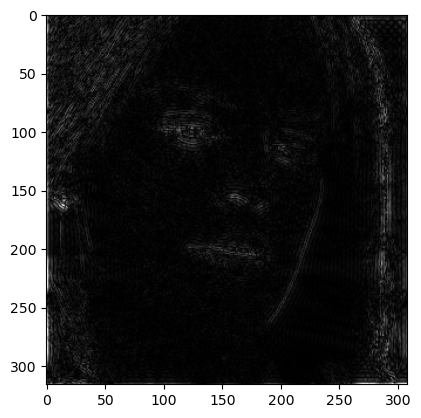

In [238]:
results = [] 
for i in range(7):
    results.append(pipeline(images[i], i))
    

In [110]:
results = np.array(list(map(lambda x : x * 255 / x.max(), results)))

/var/folders/9x/gwlwklq905339ksgb4gxg83c0000gn/T/ipykernel_42732/2444838454.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array(list(map(lambda x : x * 255 / x.max(), results)))


In [111]:
for i in results:
    print(i.mean())

7.641918706362078
3.627329279458079
5.880625069194822
13.45299102120277
8.217177381052922
10.236620356140136
10.618944993050604


In [125]:
def task2(imgs):  # for task2 : azimuthal averaging
    azs = []  # 1D power spectrums
    for i in range(7):
        fft_img = np.log(np.abs(np.fft.fftshift(fft2(imgs[i]))))
        az_ = azimuthal_averaging(fft_img)
        azs.append(az_)
        plt.plot(az_)
    # plotting
    plt.title("1D Power Spectrum")
    plt.xlabel("Spatial Frequency")
    plt.ylabel("Power Spectrum")
    # plt.ylim(0.25, 1.2)
    # plt.xlim(-20, 250)
    plt.legend([f"00{i}.jpg" for i in range(7)])
    plt.show()
    return azs

In [141]:
cropped = [ cv2.imread("./images/data/eye_cropped_00{}.jpg".format(i), cv2.IMREAD_GRAYSCALE) for i in range(7)] 

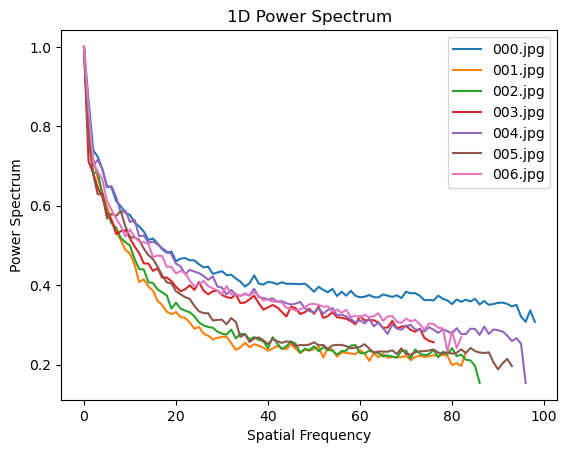

[array([1.        , 0.86538462, 0.74038462, 0.72307692, 0.69230769,
        0.65      , 0.64529915, 0.61217949, 0.5989011 , 0.58241758,
        0.57692308, 0.55769231, 0.54807692, 0.53511706, 0.51398601,
        0.51762821, 0.50480769, 0.49071618, 0.48205128, 0.48461538,
        0.46029777, 0.46688034, 0.46832579, 0.46263736, 0.46255061,
        0.45238095, 0.44493007, 0.44652908, 0.42857143, 0.43189103,
        0.43535188, 0.42529586, 0.42632067, 0.41690408, 0.40904977,
        0.39653304, 0.40506329, 0.42470206, 0.40408958, 0.40147524,
        0.40828402, 0.40659341, 0.40245262, 0.40717949, 0.40356745,
        0.4035503 , 0.40303359, 0.40245262, 0.40413318, 0.39464883,
        0.38353196, 0.39576366, 0.38816568, 0.38231917, 0.39053254,
        0.37269772, 0.38343195, 0.37346711, 0.38583639, 0.37313433,
        0.36969001, 0.37083812, 0.37514793, 0.36969001, 0.36923077,
        0.37657865, 0.37362637, 0.3704142 , 0.37458194, 0.36752137,
        0.38343195, 0.37973138, 0.38002296, 0.37

In [142]:
task2(cropped)

(63, 187)
(52, 159)
(50, 166)


/var/folders/9x/gwlwklq905339ksgb4gxg83c0000gn/T/ipykernel_42732/506778199.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.abs(np.log(highpass_img)), cmap='gray')


(38, 148)
(58, 184)
(67, 177)
(57, 157)


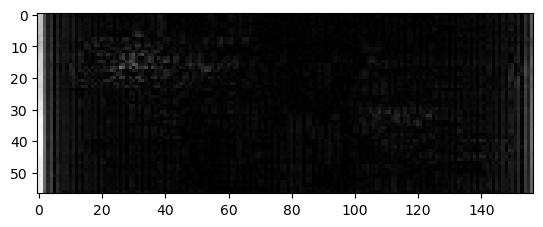

In [171]:
cropped_result = []
for i in range(7):
    h, w = cropped[i].shape
    cropped_image = pipeline(cropped[i], i)[np.ix_(range(h), range(5, w - 5))]
    # cropped_image = pipeline(cropped[i], i)
    cropped_result.append(cropped_image)
    
    

In [172]:
for i, res in enumerate(cropped_result):
    # plt.imshow(res)
    # plt.savefig("./images/inversed/eye_cropped_00{}.jpg".format(i))
    cv2.imwrite("./images/inversed/eye_cropped_00{}.jpg".format(i), 5 * res)

In [177]:
for i in cropped_result:
    h, w = i.shape 
    sum_ = 0
    thres = i.mean()
    for i_ in range(h):
        for j_ in range(w):
            if i[i_][j_] > thres:
                sum_ += 1 
    print(sum_)

3907
2915
2871
1791
3764
4364
3082


In [229]:
loc = [
    np.ix_(range(70, 150), range(60, 260)),
    np.ix_(range(120, 160), range(0, 160)),
    np.ix_(range(80, 120), range(75, 225)),
    np.ix_(range(80, 130), range(75, 255)),
    np.ix_(range(80, 140), range(75, 255)),
    np.ix_(range(80, 140), range(75, 255)),
    np.ix_(range(80, 140), range(70, 230)),
]

In [239]:
eye_cropped = [] 
for i in range(7): 
    eye_cropped.append(results[i][loc[i]])

In [242]:
for eye in eye_cropped:
    print(eye.mean())

2.779014913300988
1.2148678231026633
1.0687847769807803
3.209028462879213
2.4232438572886967
1.7173979854768613
2.6413110860490208


In [252]:
for i, eye in enumerate(eye_cropped):
    cv2.imwrite("./images/inversed/eye_00{}.jpg".format(i), 2 * eye)

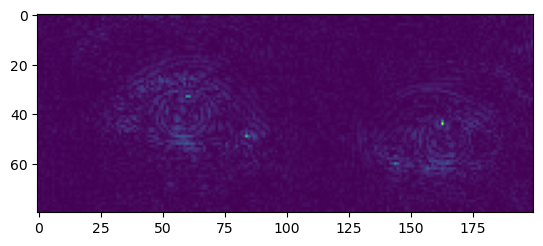

In [250]:
plt.imshow(eye_cropped[0])

In [ ]:
for i in range(7):
    cv2.imwrite("./images/data/eye_00{}.jpg".format(i), images[i][loc[i]])